# Assignment 3: LSTM and GRU vs. Multiplicative Variations

### Maxim Ryabinov (U02204083)
### CAP4641: Natural Language Processing 
### Instructor: Dr. Ankur Mali 
### University of South Florida (Spring 2025)

---

# Description

In this assignment, I implemented Standard LSTM RNN, Standard GRU RNN, Multiplicative LSTM RNN, and Multiplicative GRU RNN. My choice for the machine learning library used in this notebook is TensorFlow.

Below, you will find an implementation for each recurrent neural network architecture, all following a set of model equations that each of the architectures are based off of.

Lastly, in order to show robustness and highlight the differences in gating mechanisms between the architectures, the Copy Task is carried out. Each model is ran through this task using varying lengths of sequences that contain a randomly generated set of characters (sequences lengths: `{100, 200, 500, 1000}`).



---

# 1. Initial Setup

In [1]:
# Imports all the libraries needed.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
# seed = 123

# tf.random.set_seed(seed)
# np.random.seed(seed)

2025-03-16 19:06:40.635054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742166400.651750   41471 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742166400.657100   41471 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 19:06:40.674686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Defining each RNN Architecture

This section contains the definitions for each type of RNN implementation that will be used for the copy task.

The models are as followed:
1. Standard LSTM Model
2. Multiplicative LSTM Model
3. Standard GRU Model
4. Multiplicative GRU Model

### 1. Standard LSTM RNN Implementation

This model implements the classic Long Short-Term Memory (LSTM) cell `StandardLSTMCell`, and then uses it in the higher-level RNN structure `StandardLSTM`. The cell itself captures long-term dependencies in sequential data using the following to control the information:

- Input Gate
- Forget Gate
- Output Gate
- Cell Candidate

The `StandardLSTM` class unrolls the LSTM cell over the sequence length, extracting the input at time `t` and passing it into the LSTM cell. The hidden state is then projected into `out_t` output and the final result is returned along with the hidden state and cell candidate (this information is used during the copy test when sequences are being split).

In [2]:
class StandardLSTMCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Input gate weights
        self.W_i = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_i = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_i = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Forget gate weights
        self.W_f = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_f = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_f = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Output gate weights
        self.W_o = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_o = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_o = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Cell candidate weights
        self.W_c = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_c = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_c = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

    def call(self, x_t, h_prev, c_prev):
        i_t = tf.sigmoid(tf.matmul(x_t, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f_t = tf.sigmoid(tf.matmul(x_t, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        o_t = tf.sigmoid(tf.matmul(x_t, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        c_hat = tf.tanh(tf.matmul(x_t, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        
        c_t = f_t * c_prev + i_t * c_hat
        h_t = o_t * tf.tanh(c_t)
        
        return h_t, c_t

# ------- Higher-level TF RNN that unrolls over time -------
class StandardLSTM(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_cell = StandardLSTMCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        # Output projection
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, X, initial_state = None):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]
        
        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
            c = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h, c = initial_state

        outputs = []
        
        for t in range(seq_length):
            x_t = X[:, t, :]
            h, c = self.lstm_cell(x_t, h, c)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), (h, c)  # [batch_size, seq_length, input_size] and h, c

### 2. Multiplicative LSTM RNN Implementation

This model introduces modifications to the original RNN structure of `StandardLSTM`, including a multiplicative extension by having an additional set of weights and bias for the multiplicative layer.

This creates a learnable memory vector `m_t` and is used to calculating `x_cap_t` and being substituted for `x_t`.   

- Input Gate
- Forget Gate
- Output Gate
- Cell Candidate
- Memory Vector

Similar to the `StandardLSTM`class, the `MultiplicativeLSTM` class unrolls the `MultiplicativeLSTMCell` over the sequence length. At each time step `t`, the input is passed through the cell, which updates the hidden state and cell state. The hidden state is then projected into the output `out_t`. This process is repeated for each time step, and the final sequence of outputs is returned along with the hidden state and cell candidate (this information is used during the copy test when sequences are being split).

In [3]:
class MultiplicativeLSTMCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Input gate weights and bias
        self.W_i = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_i = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_i = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Forget gate weights and bias
        self.W_f = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_f = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_f = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Output gate weights and bias
        self.W_o = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_o = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_o = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Cell candidate weights and bias
        self.W_c = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_c = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_c = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

        # Multiplicative extension weights and bias
        self.W_m = self.add_weight(shape=(input_size, input_size), initializer="random_normal", trainable=True)
        self.U_m = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_m = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, x_t, h_prev, c_prev):
        # Multiplicative Extension
        m_t = tf.matmul(x_t, self.W_m) + tf.matmul(h_prev, self.U_m) + self.b_m
        x_cap = m_t * x_t

        i_t = tf.sigmoid(tf.matmul(x_cap, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f_t = tf.sigmoid(tf.matmul(x_cap, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        o_t = tf.sigmoid(tf.matmul(x_cap, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        c_hat = tf.tanh(tf.matmul(x_cap, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        
        c_t = f_t * c_prev + i_t * c_hat
        h_t = o_t * tf.tanh(c_t)
        
        return h_t, c_t

class MultiplicativeLSTM(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_cell = MultiplicativeLSTMCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        # Output projection
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, X, initial_state=None):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]

        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
            c = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h, c = initial_state

        outputs = []
        
        for t in range(seq_length):
            x_t = X[:, t, :]
            h, c = self.lstm_cell(x_t, h, c)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), (h, c)  # [batch_size, seq_length, input_size] and h, c

### 3. Standard GRU RNN Implementation

This model implements the Gated Recurrent Unit (GRU) cell `StandardGRUCell`, and then uses it in the higher-level RNN structure `StandardGRU`. The GRU cell is a simplified version of the LSTM cell, designed to capture long-term dependencies in sequential data. It controls the flow of information through the following components:

- Update Gate
- Reset Gate
- Candidate Hidden State

The `StandardGRU` class unrolls the GRU cell over the sequence length, extracting the input at time `t` and passing it into the GRU cell. The hidden state is then projected into the `out_t` output, and the final result is returned along with the hidden state (this information is used during the copy test when sequences are being split).

In [4]:
class StandardGRUCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Update gate weights
        self.W_z = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_z = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_z = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Reset gate weights
        self.W_r = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_r = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_r = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Candidate hidden state weights
        self.W_h = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_h = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_h = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

    def call(self, x_t, h_prev):
        # Update gate
        z_t = tf.sigmoid(tf.matmul(x_t, self.W_z) + tf.matmul(h_prev, self.U_z) + self.b_z)
        
        # Reset gate
        r_t = tf.sigmoid(tf.matmul(x_t, self.W_r) + tf.matmul(h_prev, self.U_r) + self.b_r)
        
        # Candidate hidden state
        h_hat = tf.tanh(tf.matmul(x_t, self.W_h) + tf.matmul(r_t * h_prev, self.U_h) + self.b_h)
        
        # New hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_hat
        
        return h_t

# ------- Higher-level TF RNN that unrolls over time -------
class StandardGRU(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru_cell = StandardGRUCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn

        # Output projection
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, X, initial_state=None):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]
        
        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h = initial_state

        outputs = []
        
        for t in range(seq_length):
            x_t = X[:, t, :]
            h = self.gru_cell(x_t, h)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), h  # [batch_size, seq_length, input_size] and h

### 4. Multiplicative GRU RNN Implementation

This model implements the Multiplicative Gated Recurrent Unit (GRU) cell `MultiplicativeGRUCell`, and then uses it in the higher-level RNN structure `MultiplicativeGRU`. The Multiplicative GRU introduces a multiplicative extension to the original GRU cell. It is used to capture long-term dependencies in sequential data using the following components:

- Update Gate
- Reset Gate
- Candidate Hidden State
- Memory Vector

The `MultiplicativeGRU` class unrolls the GRU cell over the sequence length, extracting the input at `time t` and passing it into the GRU cell. The hidden state is then projected into the `out_t` output, and the final result is returned along with the hidden state (this information is used during the copy test when sequences are being split).


In [5]:
class MultiplicativeGRUCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Update gate weights
        self.W_z = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_z = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_z = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Reset gate weights
        self.W_r = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_r = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_r = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Candidate hidden state weights
        self.W_h = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_h = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_h = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

        # Multiplicative extension weights and bias
        self.W_m = self.add_weight(shape=(input_size, input_size), initializer="random_normal", trainable=True)
        self.U_m = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_m = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, x_t, h_prev):
        # Memory matrix introduction
        m_t = tf.matmul(x_t, self.W_m) + tf.matmul(h_prev, self.U_m) + self.b_m
        x_cap = m_t * x_t

        # Update gate
        z_t = tf.sigmoid(tf.matmul(x_cap, self.W_z) + tf.matmul(h_prev, self.U_z) + self.b_z)
        
        # Reset gate
        r_t = tf.sigmoid(tf.matmul(x_cap, self.W_r) + tf.matmul(h_prev, self.U_r) + self.b_r)
        
        # Candidate hidden state
        h_hat = tf.tanh(tf.matmul(x_cap, self.W_h) + tf.matmul(r_t * h_prev, self.U_h) + self.b_h)
        
        # New hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_hat
        
        return h_t

# ------- Higher-level TF RNN that unrolls over time -------
class MultiplicativeGRU(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru_cell = MultiplicativeGRUCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        # Output projection
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, X, initial_state=None):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]
        h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        
        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h = initial_state

        outputs = []
        
        for t in range(seq_length):
            x_t = X[:, t, :]
            h = self.gru_cell(x_t, h)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), h  # [batch_size, seq_length, input_size] and h

# 3. Running the Copy Task

### Train, Test, and Validation Splits

This function is in charge of generating the random sequences used for the copy task. In order for the copy task to work, it also adds a few delimiters at the end of the generated sequence.

The X and Y datasets generated represent the input sequences for the model and the target output sequences that the model should be able to regenerate through the RNN.

In [11]:
# Generates dataset splits.
def generate_dataset_splits(sequence_count, input_size, training_length, sequence_length, delimiter, total_delimiters):
    # Generates random sequences of integers between 0 and 9 (10 is used as the delimiter in my testing).
    X_train = np.random.randint(0, 10, size=(sequence_count, training_length-total_delimiters, input_size)).astype(np.float32)
    X_val = np.random.randint(0, 10, size=(sequence_count, training_length-total_delimiters, input_size)).astype(np.float32)
    X_test = np.random.randint(0, 10, size=(sequence_count, sequence_length-total_delimiters, input_size)).astype(np.float32)
    delimiters = np.full((sequence_count, total_delimiters, input_size), delimiter, dtype=np.float32)
    
    # Concatenates the delimiters to the end of the sequences.
    X_train = np.concatenate([X_train, delimiters], axis=1)
    X_val = np.concatenate([X_val, delimiters], axis=1)
    X_test = np.concatenate([X_test, delimiters], axis=1)
    
    # Copies the input sequences to be used as the target sequences
    Y_train = X_train.copy()
    Y_val = X_val.copy()
    Y_test = X_test.copy()
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

### Training and Validating the Model (Training Loop)

This function simply defines the training process for the model. It will train the model multiple times depending on the number of epochs (ten by default).

The function outputs relevant data to the training process:
- Current Epoch
- Training Loss
- Validation Loss
- Training Accuracy
- Validation Accuracy

This is also accompanied with a plot generated, showing the relationship between loss and accuracy over epochs for both the validation and training datasets.

In [7]:
# Trains the model and plots the training and validation loss and accuracy.
def train_model(model, X_train, Y_train, X_val, Y_val):
    # Convert numpy arrays to tensors
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
    X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
    Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)
    
    # Used for plotting the graphs (just stores data during training). 
    train_loss_data = []
    val_loss_data = []
    train_accuracy_data = []
    val_accuracy_data = []
    
    # Training loop.
    for epoch in range(model.epochs):
        # Shuffle training data at the start of each epoch.
        indices = tf.range(start=X_train.shape[0])
        indices = tf.random.shuffle(indices)
        X_train = tf.gather(X_train, indices)
        Y_train = tf.gather(Y_train, indices)
        
        # Variables used to calculate the loss during each epoch.
        epoch_loss = 0
        num_batches = int(np.ceil(X_train.shape[0] / model.batch_size))

        # Loops through each batch.
        for i in range(num_batches):
            # Slices the data into batches.
            start = i * model.batch_size
            end = min((i+1) * model.batch_size, X_train.shape[0])
            X_batch = X_train[start:end]
            Y_batch = Y_train[start:end]
            
            # Converts the target sequences to labels (since I am using SparseCategoricalCrossentropy).
            Y_batch_labels = tf.argmax(Y_batch, axis=-1)
            
            # Forward pass and loss calculation.
            with tf.GradientTape() as tape:
                output, _ = model(X_batch)
                batch_loss = model.loss_fn(Y_batch_labels, output)
            gradients = tape.gradient(batch_loss, model.trainable_variables) # Calculate gradients.
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # Update weights for the model.
            
            epoch_loss += batch_loss.numpy()

        # Calculate average loss for the current epoch.
        epoch_loss /= num_batches
        
        # Calculates training accuracy.
        train_preds = np.argmax(output.numpy(), axis=-1).flatten()
        true_train = Y_batch_labels.numpy().flatten()
        train_accuracy = np.mean(train_preds == true_train)
        
        # Calculates validation loss and accuracy.
        val_output, _ = model(X_val)
        val_loss = model.loss_fn(tf.argmax(Y_val, axis=-1), val_output).numpy()
        val_preds = np.argmax(val_output.numpy(), axis=-1)
        true_val = tf.argmax(Y_val, axis=-1).numpy()
        val_accuracy = np.mean(val_preds == true_val)
        
        # Stores metrics for plotting later.
        train_loss_data.append(epoch_loss)
        val_loss_data.append(val_loss)
        train_accuracy_data.append(train_accuracy)
        val_accuracy_data.append(val_accuracy)
        
        print(f"Epoch {epoch+1:02d} | Training Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Training Accuracy: {train_accuracy:.4f} | Val Accuracy: {val_accuracy:.4f}")
        
    # After training loop, a plot for the training and validation loss and accuracy is generated.
    plt.figure(figsize=(10, 6))
    
    # Training data
    plt.plot(train_loss_data, label="Training Loss", marker=".", color="#1f77b4")
    plt.plot(train_accuracy_data, label="Training Accuracy", marker=".", color="#66c2ff")
    
    # Validation data
    plt.plot(val_loss_data, label="Validation Loss", marker=".", color="#d62728")
    plt.plot(val_accuracy_data, label="Validation Accuracy", marker=".", color="#ff7f7f")

    plt.xticks(range(len(train_loss_data))) # To display all epochs on x axis.

    # Defines the labels and title.
    plt.xlabel("Epoch")
    plt.ylabel("Loss and Accuracy")
    plt.title("Training and Validation Loss/Accuracy")
    plt.legend()
    plt.show()

### Evaluating the Model (Test Loop)

This function takes a trained model and evaluates its performance based the test sequences generated with varying lengths.

The function also outputs the following performance metrics:
- Segment Loss and Accuracy (if test sequence length is greater than training sequence length).
- Final Loss
- Final Accuracy

In [8]:
# Tests the model and prints the final test loss and accuracy.
def test_model(model, X_test, Y_test, sequence_length, training_length=100):
    # Convert numpy arrays to tensors.
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int32)
    
    # Variables used to calculate the loss during testing.
    test_loss = 0
    hidden_state = None # Used to keep the hidden state between segments (if test sequence length > train sequence length).
    num_test_segments = sequence_length // training_length

    all_test_preds = []  # Collect all predictions for final accuracy
    all_true_test = []   # Collect all true labels for final accuracy

    # Loops through each segment of the test data.
    for i in range(num_test_segments):
        # Determines the start and end slice of a segment.
        start = i * training_length
        end = start + training_length
        
        # Slices the data into segments.
        X_segment = X_test[:, start:end, :]
        Y_segment = tf.argmax(Y_test[:, start:end, :], axis=-1)

        # Checks if we are looking at the first segment or if we need to carry forward the hidden state.
        if hidden_state is None:
            output, hidden_state = model(X_segment) 
        else:
            output, hidden_state = model(X_segment, initial_state=hidden_state)

        # Calculates loss for the segment.
        segment_loss = model.loss_fn(Y_segment, output).numpy()
        test_loss += segment_loss

        # Calculates accuracy for the segment.
        test_preds = np.argmax(output.numpy(), axis=-1)
        true_test = Y_segment.numpy()

        # Collect for final accuracy calculation.
        all_test_preds.append(test_preds)
        all_true_test.append(true_test)
        
        # If multiple segments are present, this just prints out the loss and accuracy for each segment for additional analysis.
        if num_test_segments > 1:
            segment_accuracy = np.mean(test_preds == true_test)
            print(f"Segment {i + 1:02d}/{num_test_segments:02d} | Loss: {segment_loss:.4f} | Accuracy: {segment_accuracy:.4f}")

    # Calculates the average loss for all segments.
    test_loss /= num_test_segments

    # Combines all the predictions and labels for a final accuracy.
    all_test_preds = np.concatenate(all_test_preds, axis=1)
    all_true_test = np.concatenate(all_true_test, axis=1)
    test_accuracy = np.mean(all_test_preds == all_true_test)
    
    print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Accuracy: {test_accuracy:.4f}")
    
    return (test_loss, test_accuracy)
    

### Setting up the Copy Task Experiment

This function defines the overall copy task. It first defines the various settings as well as the hyper-parameters used across all models for a fair comparison. The function will then iterate through multiple trials (three in this case) across all sequence lengths, making sure to test each model. Finally, during the trial process, it outputs the following data for later analysis:

- Trial information
- Current model being trained
- Sequence length being tested
- Losses and accuracies during both training/validation and testing
- Graphs showing the relationships between the training and validation losses and accuracies.
- Final metric reports for all four models after a given sequence length has been tested
- A final report overview across all trials of the mean accuracy and loss as well as standard error for both metrics

In [9]:
# Runs a benchmark for the models.
def run_copytask_benchmark():
    # Constants used for the benchmark.
    vocabulary = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    delimiter = 10
    sequence_lengths = [100, 200]#, 500, 1000]
    sequence_count = 100 # Number of sequences to generate for training, validation, and testing (same across all models and sequence lengths testing for fair comparison).
    total_delimiters = 3 # Adds a few delimiters to make it clear that its the end of the sequence.
    
    # Hyper-parameters used across each model
    input_size = len(vocabulary) + 1 # Vocabulary tokens + delimiter token (just the number of unique tokens overall).
    hidden_size = 128 # Number of hidden units in the LSTM/GRU.
    training_length = 100 # Length of the training sequences.
    total_epochs = 3 #10 # Number of epochs to train each model.
    batch_size = 16 #32 # Batch size for training.
    learning_rate = 0.01 # Learning rate for the optimizer.
    
    # Storing and printing the training and testing status of each trial along with some analytical information.
    total_trials = 3
    
    # Creates a dictionary to store the metrics for each model. For each model, it stores a nested list that represents each sequence length,
    # where each of those lists contain tuples representing the average accuracy/loss pairs for that sequence length of that specific model.
    # 
    # The structure of this as follows:
    # {
    #     "Standard LSTM": [
    #         [(loss, accuracy), (loss, accuracy), ...],
    #         [(loss, accuracy), (loss, accuracy), ...],
    #         ...
    #     ],
    #     "Multiplicative LSTM": [
    #         [(loss, accuracy), (loss, accuracy), ...],
    #         ...
    #     ],
    #     "Standard GRU": [...],
    #     ...
    # }
    
    metrics = {"Standard LSTM": [], "Multiplicative LSTM": [], "Standard GRU": [], "Multiplicative GRU": []}
    
    for model_name, model_metrics in metrics.items():
        for sequence in sequence_lengths:
            metrics[model_name].append([])
    
    # Loops through each trial.
    for trial in range(total_trials):
        print(f"Running Trial {trial+1}/{total_trials} ================================================================================")
        # Loops through each sequence length.
        for i, sequence_length in enumerate(sequence_lengths):
            # Clears and redefines the models for each sequence length to prevent any carryover training from trials.
            models = {
                "Standard LSTM": StandardLSTM(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)),
                
                "Multiplicative LSTM": MultiplicativeLSTM(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)),
                
                "Standard GRU": StandardGRU(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)),
                
                "Multiplicative GRU": MultiplicativeGRU(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
            }
            
            # Loops through each model and trains and tests them on a given sequence length.
            for model_name, model in models.items():
                print(f"Training {model_name}:")
                # Generates the dataset splits for training, validation, and testing.
                X_train, X_val, X_test, Y_train, Y_val, Y_test = generate_dataset_splits(sequence_count,
                                                                                         input_size,
                                                                                         training_length,
                                                                                         sequence_length,
                                                                                         delimiter,
                                                                                         total_delimiters)
                # Trains the model and reports the training and validation loss and accuracy.
                train_model(model, X_train, Y_train, X_val, Y_val)
                
                # Tests the model and reports the final test loss and accuracy.
                print(f"\nTest Sequence Length: {sequence_length}")
                print(f'Testing {model_name}:')
                result_metrics = test_model(model, X_test, Y_test, sequence_length, training_length)
                metrics[model_name][i].append(result_metrics) # Stores (loss, accuracy) pair into metrics.
                print("-------------------------------------------------------------------------------------------------------")

            # Reports the final metrics for each model for a given sequence length being tested.
            print(f"*** Final metrics report for Trial {trial+1}/{total_trials} on sequence length of {sequence_length} ***")
            for model_name, model_metrics in metrics.items():
                print(model_name)
                print(f"Final Test Loss: {model_metrics[i][trial][0]:.4f}")
                print(f"Final Test Accuracy: {model_metrics[i][trial][1]:.4f}\n")

            print("=======================================================================================================")
            
    # Reports the mean performance (accuracy) and standard error of each model for each sequence across the total trials.
    print("\n===================================== Final Metrics Report =====================================\n")

    # Defines the format for the output.
    header_format = "{:<22} {:<22} {:<22} {:<22} {:<22} {:<22}"
    data_format = "{:<22} {:<22} {:<22.4f} {:<22.4f} {:<22.4f} {:<22.4f}"
    print(header_format.format("Model", "Sequence Length", "Mean Accuracy", "Std Error Accuracy", "Mean Loss", "Std Error Loss"))

    # Loops through the metrics stored for each model and reports mean accuracy and loss for each sequence length across the trials done.
    for model_name, model_metrics in metrics.items():
        for i, sequence_length in enumerate(sequence_lengths):
            accuracies = [trial[1] for trial in model_metrics[i]]  # Extract accuracy values
            losses = [trial[0] for trial in model_metrics[i]]  # Extract loss values
            
            # Calculates mean and standard error for accuracy and loss.
            mean_accuracy = np.mean(accuracies)
            mean_loss = np.mean(losses)
            std_error_accuracy = np.std(accuracies) / np.sqrt(len(accuracies))
            std_error_loss = np.std(losses) / np.sqrt(len(losses))

            # Prints the model and its corresponding metrics for each sequence length.
            print(data_format.format(model_name, sequence_length, mean_accuracy, std_error_accuracy, mean_loss, std_error_loss))

### Running Copy Task and Analyzing the Results

Run this cell when you are ready to run the copy task. As previously mentioned the output below will display data regarding the training and testing process across all the trials, as well as provide a report once the trials are concluded.

Here is the overall structure of the output:
- Current trial run
    - Current sequence being tested
        - Training loop (epochs, training loss/accuracy, validation loss/accuracy)
        - Graph plotting the relationship between loss/accuracy for training and validation across each epoch.
        - Test loop (sequence loss and accuracy if needed, final loss and accuracy) 

Running Trial 1/3 ================================================================================
Training Standard LSTM:


2025-03-16 19:06:43.105326: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 01 | Training Loss: 2.1787 | Val Loss: 1.8626 | Training Accuracy: 0.3932 | Val Accuracy: 0.4056
Epoch 02 | Training Loss: 1.5505 | Val Loss: 1.2174 | Training Accuracy: 0.6165 | Val Accuracy: 0.6359
Epoch 03 | Training Loss: 1.0320 | Val Loss: 0.8676 | Training Accuracy: 0.7184 | Val Accuracy: 0.7592


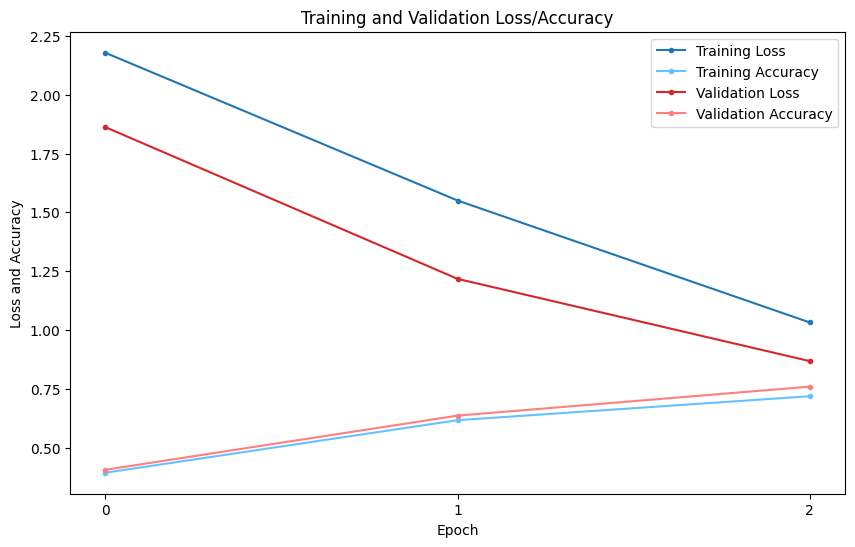


Test Sequence Length: 100
Testing Standard LSTM:

Final Test Loss: 0.8857 | Final Test Accuracy: 0.7569
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.1760 | Val Loss: 1.8403 | Training Accuracy: 0.3981 | Val Accuracy: 0.3936
Epoch 02 | Training Loss: 1.5774 | Val Loss: 1.3423 | Training Accuracy: 0.5291 | Val Accuracy: 0.5494
Epoch 03 | Training Loss: 1.1587 | Val Loss: 1.0425 | Training Accuracy: 0.6917 | Val Accuracy: 0.6497


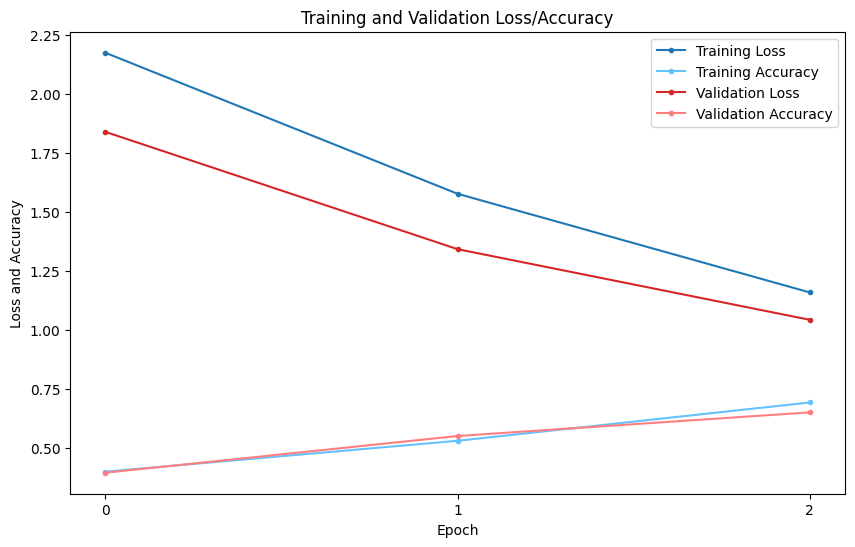


Test Sequence Length: 100
Testing Multiplicative LSTM:

Final Test Loss: 1.0767 | Final Test Accuracy: 0.6450
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.1643 | Val Loss: 1.7297 | Training Accuracy: 0.4078 | Val Accuracy: 0.4696
Epoch 02 | Training Loss: 1.4709 | Val Loss: 1.1392 | Training Accuracy: 0.6626 | Val Accuracy: 0.6866
Epoch 03 | Training Loss: 0.9886 | Val Loss: 0.7990 | Training Accuracy: 0.7694 | Val Accuracy: 0.7786


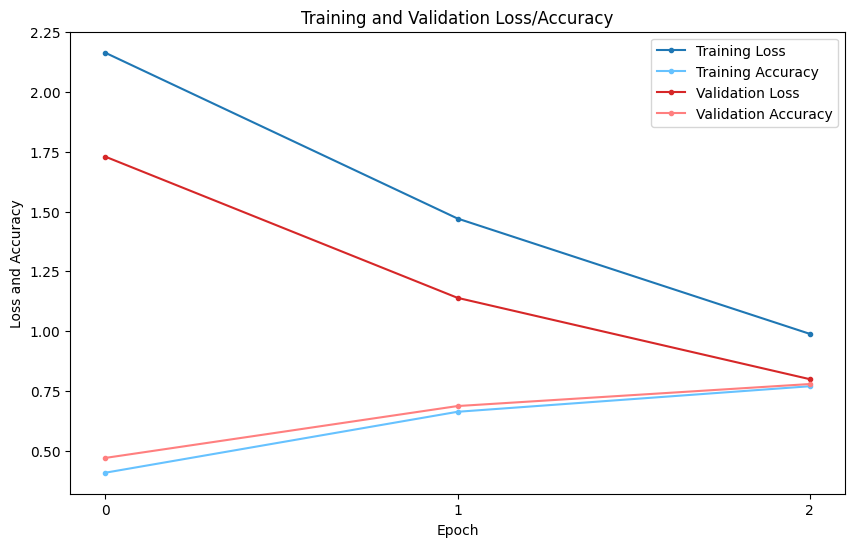


Test Sequence Length: 100
Testing Standard GRU:

Final Test Loss: 0.8255 | Final Test Accuracy: 0.7719
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.1689 | Val Loss: 1.7688 | Training Accuracy: 0.3762 | Val Accuracy: 0.4036
Epoch 02 | Training Loss: 1.5223 | Val Loss: 1.2844 | Training Accuracy: 0.5728 | Val Accuracy: 0.5490
Epoch 03 | Training Loss: 1.1065 | Val Loss: 0.9103 | Training Accuracy: 0.6189 | Val Accuracy: 0.6815


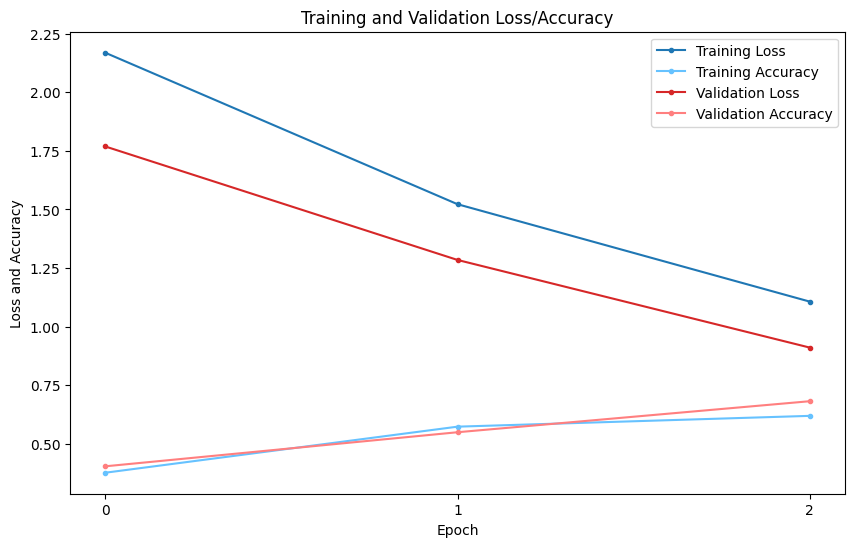


Test Sequence Length: 100
Testing Multiplicative GRU:

Final Test Loss: 0.9562 | Final Test Accuracy: 0.6659
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 1/3 on sequence length of 100 ***
Standard LSTM
Final Test Loss: 0.8857
Final Test Accuracy: 0.7569

Multiplicative LSTM
Final Test Loss: 1.0767
Final Test Accuracy: 0.6450

Standard GRU
Final Test Loss: 0.8255
Final Test Accuracy: 0.7719

Multiplicative GRU
Final Test Loss: 0.9562
Final Test Accuracy: 0.6659

Training Standard LSTM:
Epoch 01 | Training Loss: 2.1779 | Val Loss: 1.8567 | Training Accuracy: 0.4369 | Val Accuracy: 0.4506
Epoch 02 | Training Loss: 1.5643 | Val Loss: 1.2750 | Training Accuracy: 0.6602 | Val Accuracy: 0.5926
Epoch 03 | Training Loss: 1.0823 | Val Loss: 0.9047 | Training Accuracy: 0.7621 | Val Accuracy: 0.7441


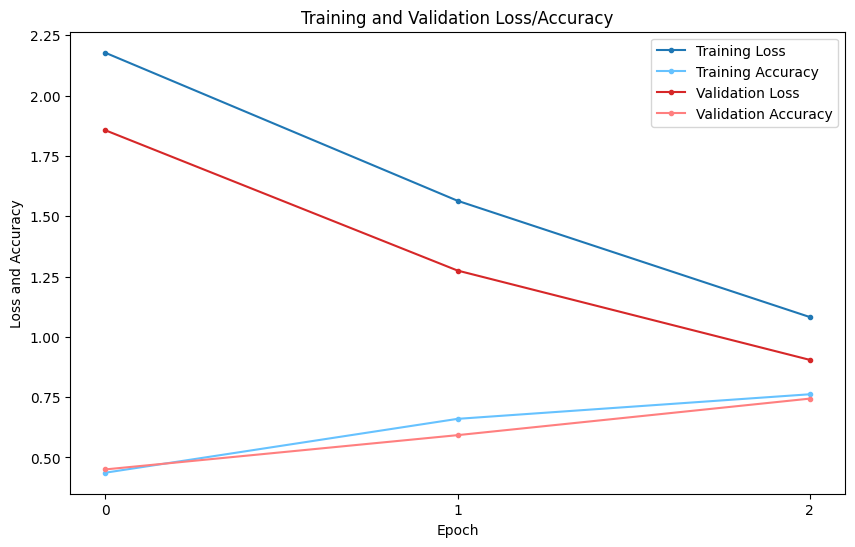


Test Sequence Length: 200
Testing Standard LSTM:
Segment 01/02 | Loss: 0.9323 | Accuracy: 0.7270
Segment 02/02 | Loss: 0.9269 | Accuracy: 0.7322

Final Test Loss: 0.9296 | Final Test Accuracy: 0.7296
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.1610 | Val Loss: 1.7736 | Training Accuracy: 0.3617 | Val Accuracy: 0.4379
Epoch 02 | Training Loss: 1.4852 | Val Loss: 1.1932 | Training Accuracy: 0.6117 | Val Accuracy: 0.5972
Epoch 03 | Training Loss: 1.0446 | Val Loss: 0.9221 | Training Accuracy: 0.6893 | Val Accuracy: 0.7021


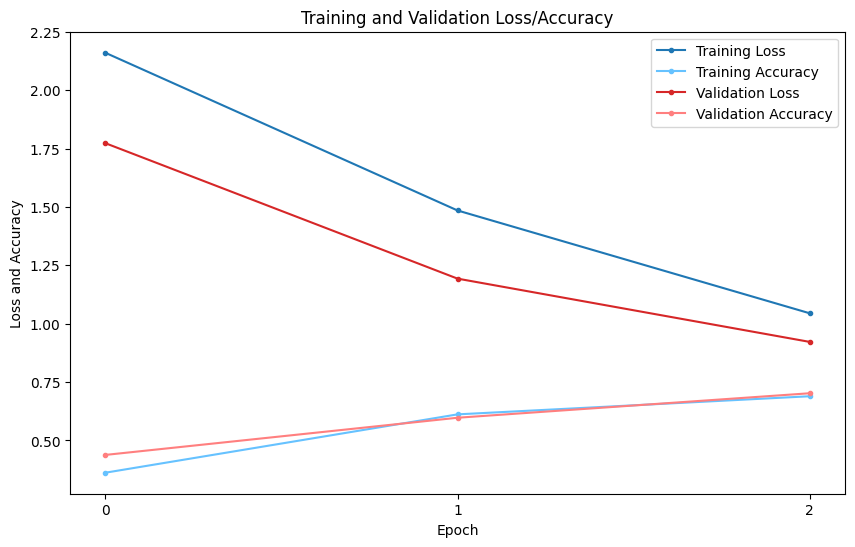


Test Sequence Length: 200
Testing Multiplicative LSTM:
Segment 01/02 | Loss: 0.9321 | Accuracy: 0.6999
Segment 02/02 | Loss: 0.9337 | Accuracy: 0.7028

Final Test Loss: 0.9329 | Final Test Accuracy: 0.7014
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.1347 | Val Loss: 1.7183 | Training Accuracy: 0.4126 | Val Accuracy: 0.4551
Epoch 02 | Training Loss: 1.4418 | Val Loss: 1.1514 | Training Accuracy: 0.6893 | Val Accuracy: 0.6662
Epoch 03 | Training Loss: 0.9783 | Val Loss: 0.8230 | Training Accuracy: 0.7379 | Val Accuracy: 0.7521


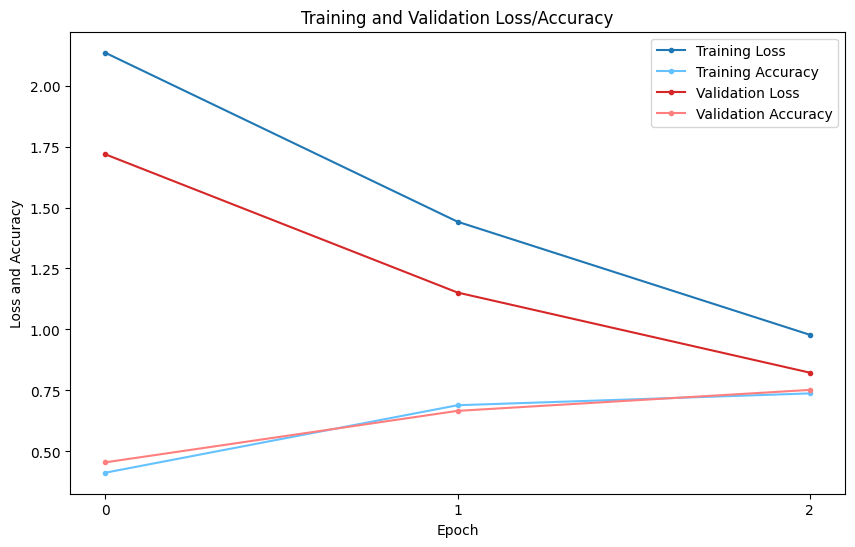


Test Sequence Length: 200
Testing Standard GRU:
Segment 01/02 | Loss: 0.8448 | Accuracy: 0.7454
Segment 02/02 | Loss: 0.8295 | Accuracy: 0.7556

Final Test Loss: 0.8372 | Final Test Accuracy: 0.7505
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.1530 | Val Loss: 1.8009 | Training Accuracy: 0.4126 | Val Accuracy: 0.4271
Epoch 02 | Training Loss: 1.5631 | Val Loss: 1.3767 | Training Accuracy: 0.5437 | Val Accuracy: 0.5328
Epoch 03 | Training Loss: 1.1807 | Val Loss: 1.0626 | Training Accuracy: 0.6335 | Val Accuracy: 0.6322


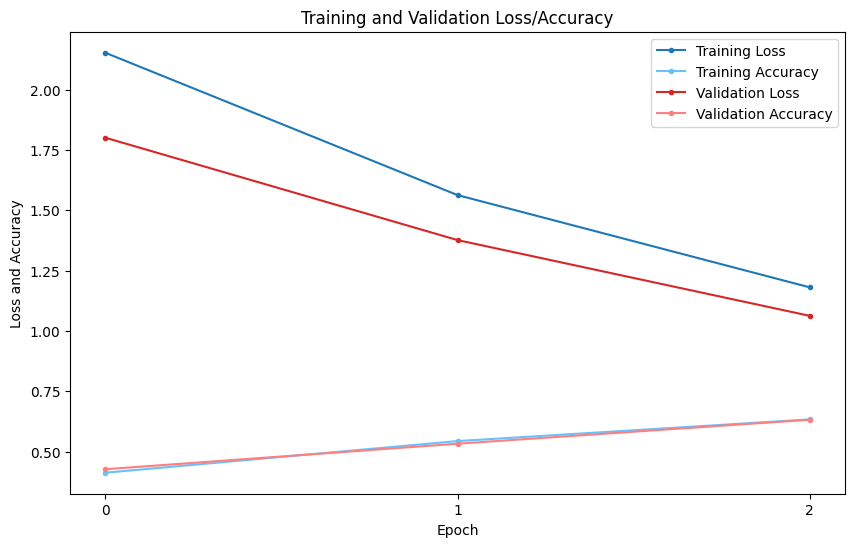


Test Sequence Length: 200
Testing Multiplicative GRU:
Segment 01/02 | Loss: 1.0688 | Accuracy: 0.6349
Segment 02/02 | Loss: 1.0564 | Accuracy: 0.6334

Final Test Loss: 1.0626 | Final Test Accuracy: 0.6341
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 1/3 on sequence length of 200 ***
Standard LSTM
Final Test Loss: 0.9296
Final Test Accuracy: 0.7296

Multiplicative LSTM
Final Test Loss: 0.9329
Final Test Accuracy: 0.7014

Standard GRU
Final Test Loss: 0.8372
Final Test Accuracy: 0.7505

Multiplicative GRU
Final Test Loss: 1.0626
Final Test Accuracy: 0.6341

Running Trial 2/3 ================================================================================
Training Standard LSTM:
Epoch 01 | Training Loss: 2.1365 | Val Loss: 1.7844 | Training Accuracy: 0.4563 | Val Accuracy: 0.4703
Epoch 02 | Training Loss: 1.4936 | Val Loss: 1.2276 | Training Accuracy: 0.6286 | Val Accuracy: 0.6070
Epoch 03 | Tra

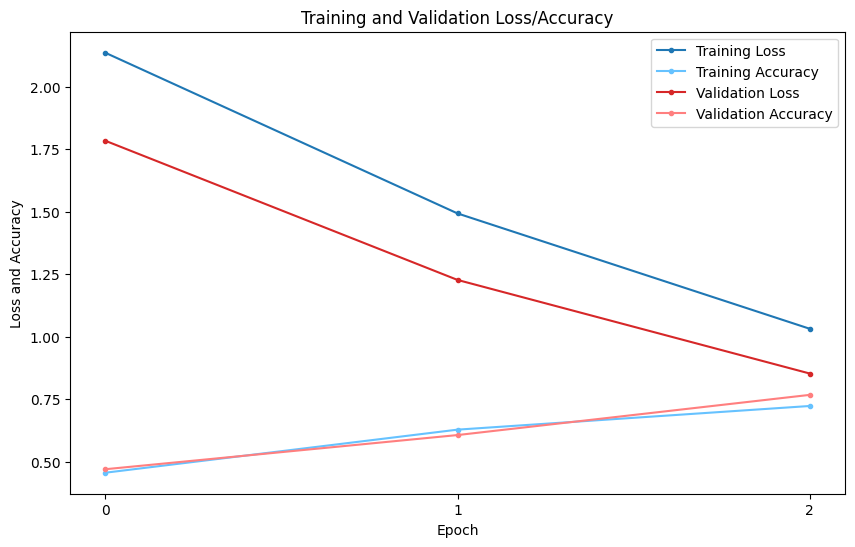


Test Sequence Length: 100
Testing Standard LSTM:

Final Test Loss: 0.8813 | Final Test Accuracy: 0.7585
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.1738 | Val Loss: 1.8635 | Training Accuracy: 0.3835 | Val Accuracy: 0.3913
Epoch 02 | Training Loss: 1.6072 | Val Loss: 1.3480 | Training Accuracy: 0.5655 | Val Accuracy: 0.5479
Epoch 03 | Training Loss: 1.1957 | Val Loss: 1.0531 | Training Accuracy: 0.6335 | Val Accuracy: 0.6291


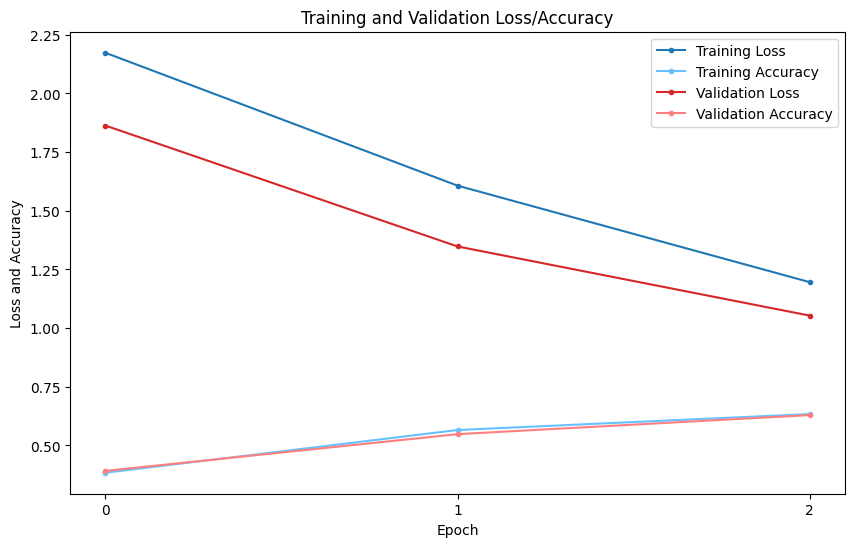


Test Sequence Length: 100
Testing Multiplicative LSTM:

Final Test Loss: 1.0845 | Final Test Accuracy: 0.6176
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.0767 | Val Loss: 1.6058 | Training Accuracy: 0.4903 | Val Accuracy: 0.5166
Epoch 02 | Training Loss: 1.3384 | Val Loss: 1.0322 | Training Accuracy: 0.6845 | Val Accuracy: 0.7119
Epoch 03 | Training Loss: 0.8819 | Val Loss: 0.7446 | Training Accuracy: 0.8204 | Val Accuracy: 0.7893


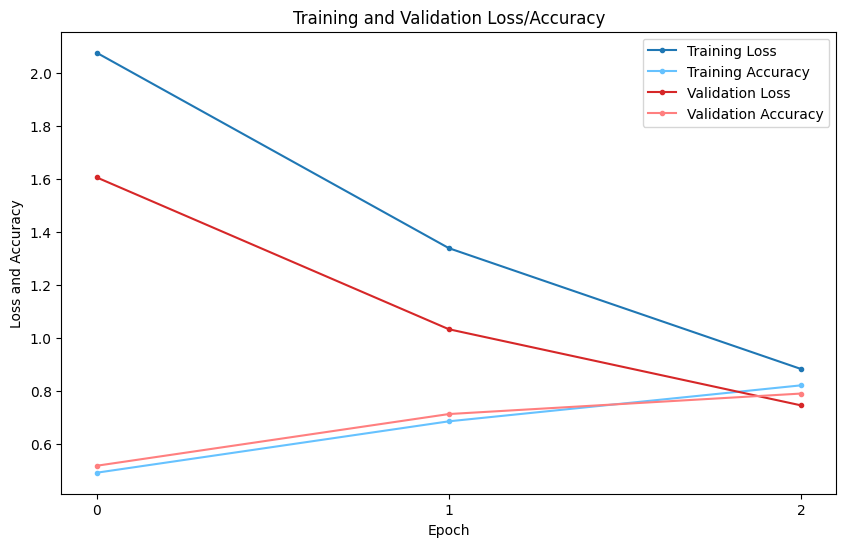


Test Sequence Length: 100
Testing Standard GRU:

Final Test Loss: 0.7734 | Final Test Accuracy: 0.7725
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.1824 | Val Loss: 1.8247 | Training Accuracy: 0.3956 | Val Accuracy: 0.3882
Epoch 02 | Training Loss: 1.5899 | Val Loss: 1.3762 | Training Accuracy: 0.5461 | Val Accuracy: 0.5265
Epoch 03 | Training Loss: 1.1942 | Val Loss: 1.0539 | Training Accuracy: 0.6165 | Val Accuracy: 0.6317


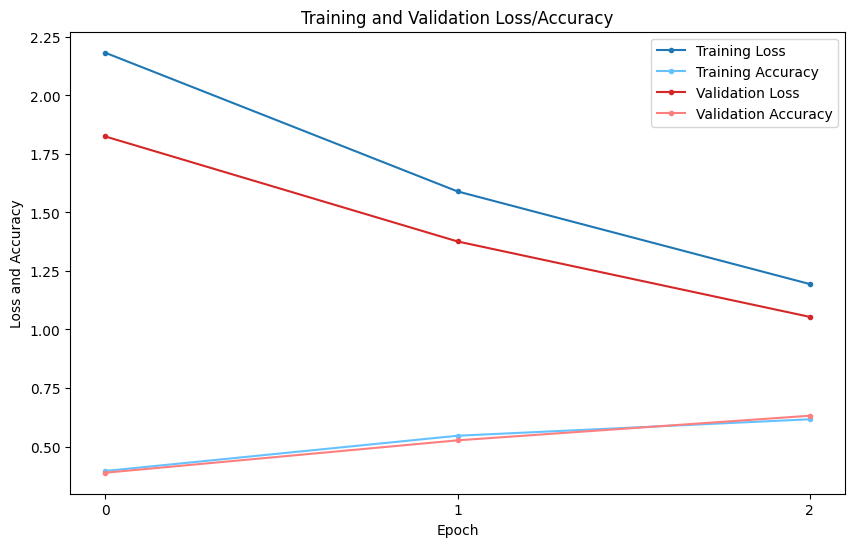


Test Sequence Length: 100
Testing Multiplicative GRU:

Final Test Loss: 1.0754 | Final Test Accuracy: 0.6180
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 2/3 on sequence length of 100 ***
Standard LSTM
Final Test Loss: 0.8813
Final Test Accuracy: 0.7585

Multiplicative LSTM
Final Test Loss: 1.0845
Final Test Accuracy: 0.6176

Standard GRU
Final Test Loss: 0.7734
Final Test Accuracy: 0.7725

Multiplicative GRU
Final Test Loss: 1.0754
Final Test Accuracy: 0.6180

Training Standard LSTM:
Epoch 01 | Training Loss: 2.1487 | Val Loss: 1.8125 | Training Accuracy: 0.5583 | Val Accuracy: 0.4983
Epoch 02 | Training Loss: 1.5364 | Val Loss: 1.2442 | Training Accuracy: 0.6626 | Val Accuracy: 0.6296
Epoch 03 | Training Loss: 1.0608 | Val Loss: 0.9143 | Training Accuracy: 0.7330 | Val Accuracy: 0.7214


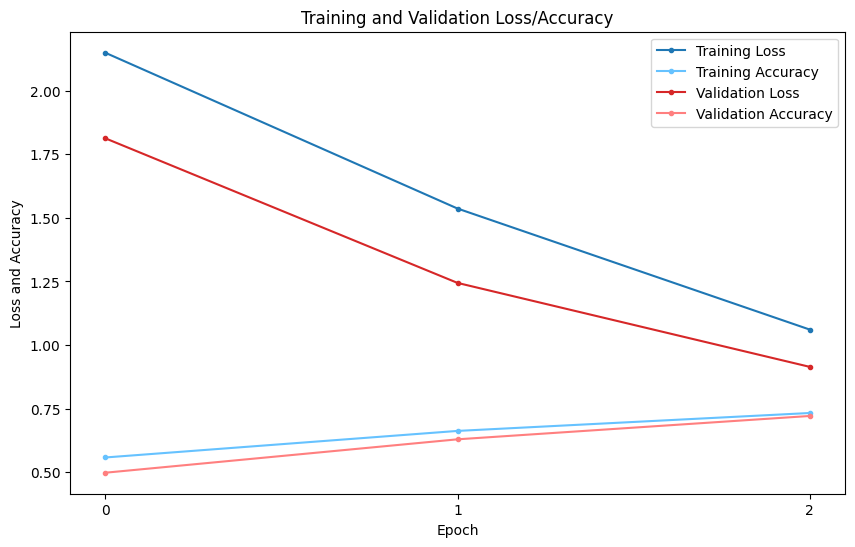


Test Sequence Length: 200
Testing Standard LSTM:
Segment 01/02 | Loss: 0.9393 | Accuracy: 0.7133
Segment 02/02 | Loss: 0.9420 | Accuracy: 0.7120

Final Test Loss: 0.9406 | Final Test Accuracy: 0.7127
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.1240 | Val Loss: 1.7833 | Training Accuracy: 0.4223 | Val Accuracy: 0.3973
Epoch 02 | Training Loss: 1.5237 | Val Loss: 1.2362 | Training Accuracy: 0.5655 | Val Accuracy: 0.5712
Epoch 03 | Training Loss: 1.0676 | Val Loss: 0.9375 | Training Accuracy: 0.6796 | Val Accuracy: 0.6666


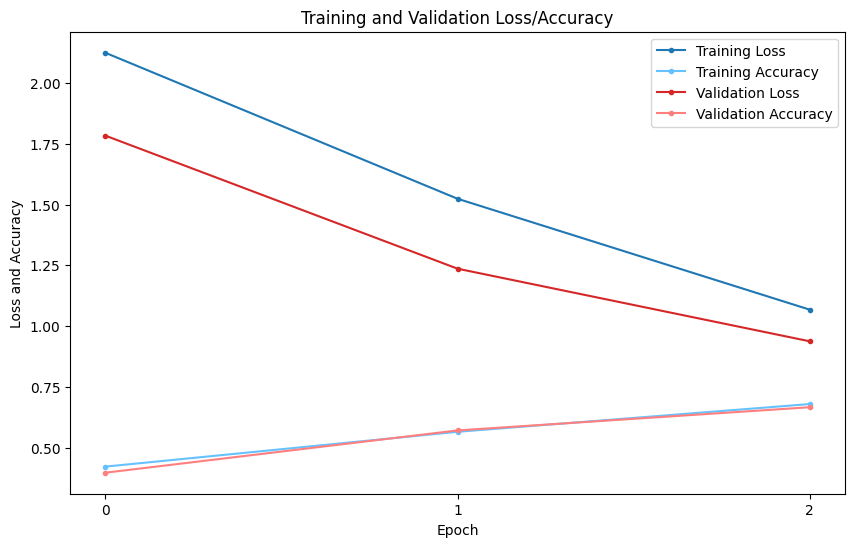


Test Sequence Length: 200
Testing Multiplicative LSTM:
Segment 01/02 | Loss: 0.9680 | Accuracy: 0.6512
Segment 02/02 | Loss: 0.9744 | Accuracy: 0.6519

Final Test Loss: 0.9712 | Final Test Accuracy: 0.6515
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.1172 | Val Loss: 1.6859 | Training Accuracy: 0.4587 | Val Accuracy: 0.4466
Epoch 02 | Training Loss: 1.4153 | Val Loss: 1.1133 | Training Accuracy: 0.6432 | Val Accuracy: 0.6805
Epoch 03 | Training Loss: 0.9579 | Val Loss: 0.8225 | Training Accuracy: 0.7087 | Val Accuracy: 0.7683


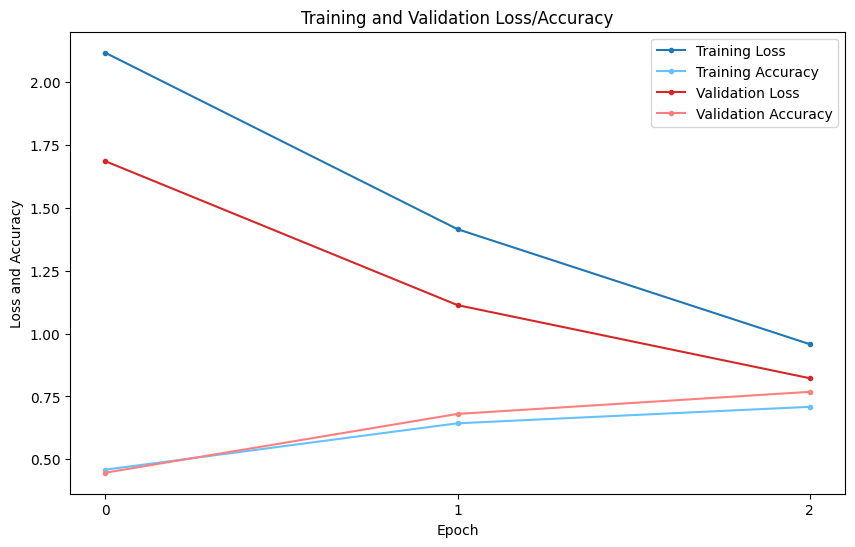


Test Sequence Length: 200
Testing Standard GRU:
Segment 01/02 | Loss: 0.8419 | Accuracy: 0.7696
Segment 02/02 | Loss: 0.8517 | Accuracy: 0.7647

Final Test Loss: 0.8468 | Final Test Accuracy: 0.7671
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.1034 | Val Loss: 1.7170 | Training Accuracy: 0.3981 | Val Accuracy: 0.4319
Epoch 02 | Training Loss: 1.5653 | Val Loss: 1.3716 | Training Accuracy: 0.5121 | Val Accuracy: 0.5316
Epoch 03 | Training Loss: 1.2051 | Val Loss: 1.1222 | Training Accuracy: 0.6262 | Val Accuracy: 0.6217


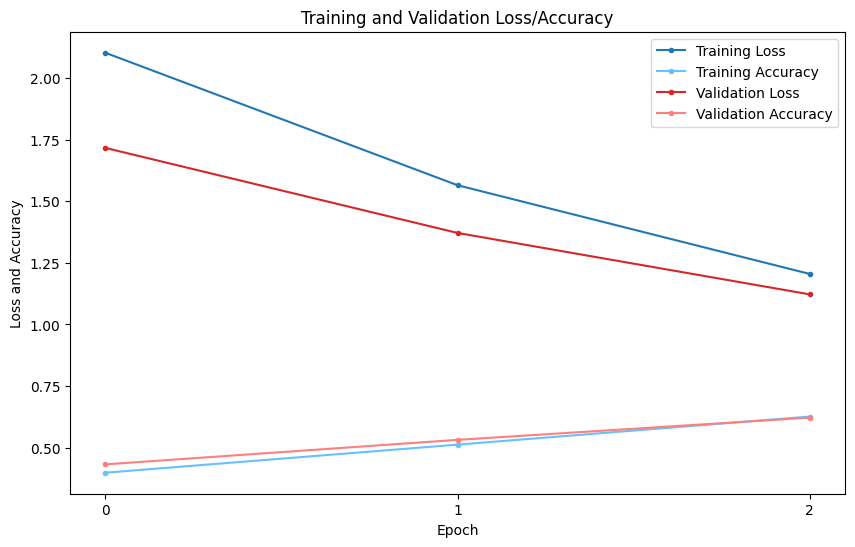


Test Sequence Length: 200
Testing Multiplicative GRU:
Segment 01/02 | Loss: 1.1787 | Accuracy: 0.6022
Segment 02/02 | Loss: 1.1562 | Accuracy: 0.6051

Final Test Loss: 1.1675 | Final Test Accuracy: 0.6037
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 2/3 on sequence length of 200 ***
Standard LSTM
Final Test Loss: 0.9406
Final Test Accuracy: 0.7127

Multiplicative LSTM
Final Test Loss: 0.9712
Final Test Accuracy: 0.6515

Standard GRU
Final Test Loss: 0.8468
Final Test Accuracy: 0.7671

Multiplicative GRU
Final Test Loss: 1.1675
Final Test Accuracy: 0.6037

Running Trial 3/3 ================================================================================
Training Standard LSTM:
Epoch 01 | Training Loss: 2.2194 | Val Loss: 1.9276 | Training Accuracy: 0.4417 | Val Accuracy: 0.4448
Epoch 02 | Training Loss: 1.6638 | Val Loss: 1.3272 | Training Accuracy: 0.5413 | Val Accuracy: 0.5959
Epoch 03 | Tra

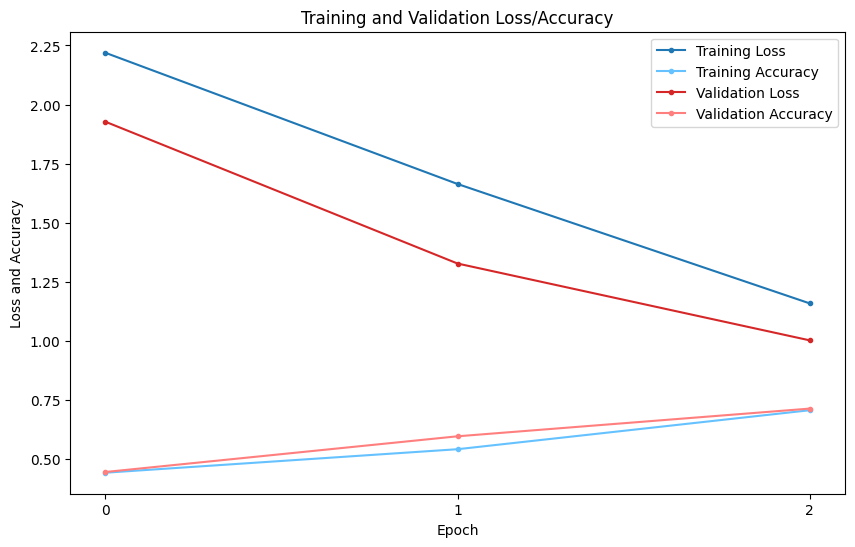


Test Sequence Length: 100
Testing Standard LSTM:

Final Test Loss: 1.0212 | Final Test Accuracy: 0.7078
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.1446 | Val Loss: 1.8296 | Training Accuracy: 0.4078 | Val Accuracy: 0.3903
Epoch 02 | Training Loss: 1.5399 | Val Loss: 1.3237 | Training Accuracy: 0.5558 | Val Accuracy: 0.5395
Epoch 03 | Training Loss: 1.1558 | Val Loss: 1.0652 | Training Accuracy: 0.6796 | Val Accuracy: 0.6364


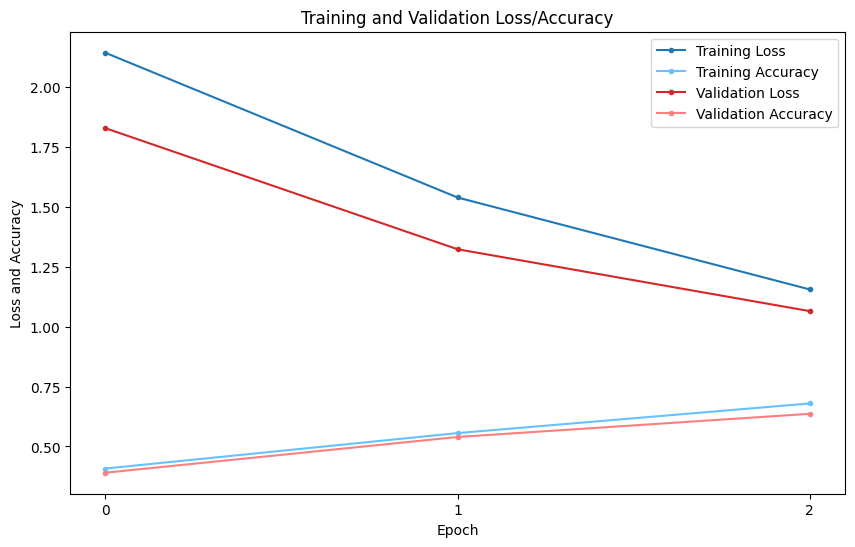


Test Sequence Length: 100
Testing Multiplicative LSTM:

Final Test Loss: 1.0753 | Final Test Accuracy: 0.6322
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.0987 | Val Loss: 1.6544 | Training Accuracy: 0.5097 | Val Accuracy: 0.4967
Epoch 02 | Training Loss: 1.3741 | Val Loss: 1.0785 | Training Accuracy: 0.6529 | Val Accuracy: 0.6881
Epoch 03 | Training Loss: 0.9213 | Val Loss: 0.7760 | Training Accuracy: 0.7718 | Val Accuracy: 0.7910


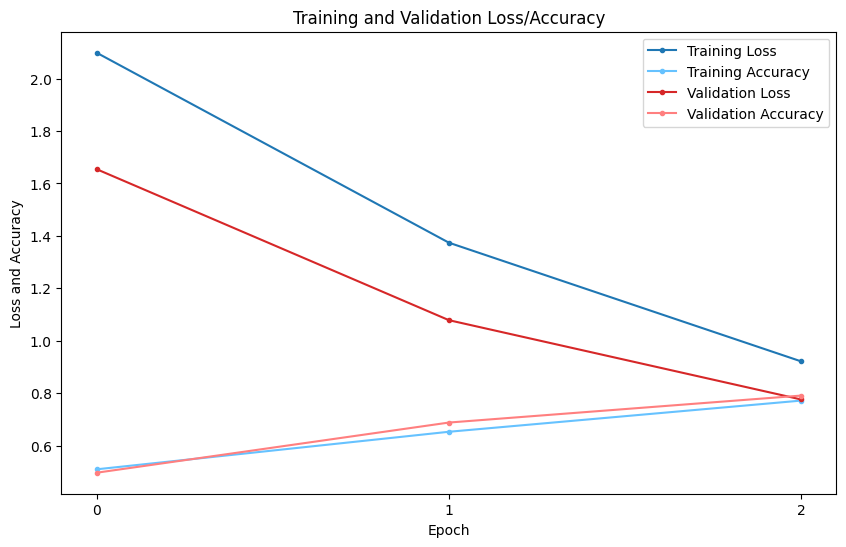


Test Sequence Length: 100
Testing Standard GRU:

Final Test Loss: 0.7907 | Final Test Accuracy: 0.7926
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.1638 | Val Loss: 1.7378 | Training Accuracy: 0.3956 | Val Accuracy: 0.4449
Epoch 02 | Training Loss: 1.4869 | Val Loss: 1.2554 | Training Accuracy: 0.5777 | Val Accuracy: 0.5866
Epoch 03 | Training Loss: 1.0888 | Val Loss: 0.9303 | Training Accuracy: 0.7063 | Val Accuracy: 0.6847


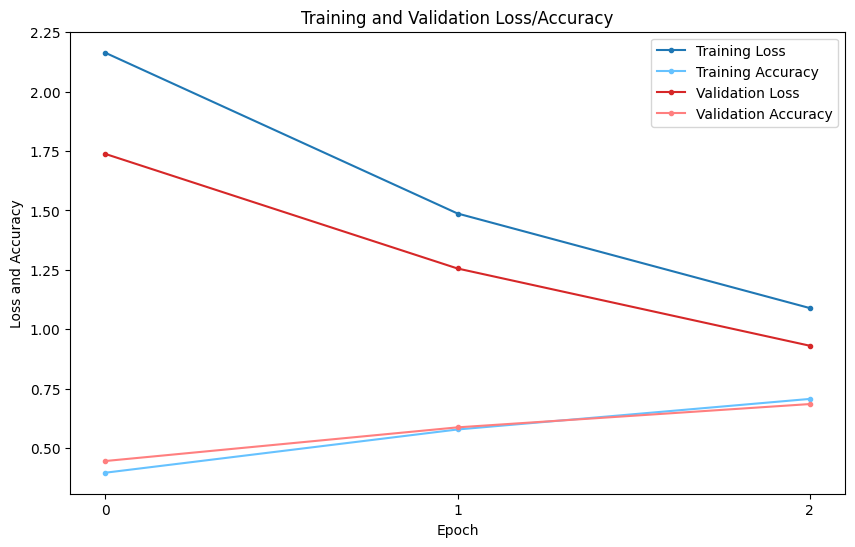


Test Sequence Length: 100
Testing Multiplicative GRU:

Final Test Loss: 0.9703 | Final Test Accuracy: 0.6732
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 3/3 on sequence length of 100 ***
Standard LSTM
Final Test Loss: 1.0212
Final Test Accuracy: 0.7078

Multiplicative LSTM
Final Test Loss: 1.0753
Final Test Accuracy: 0.6322

Standard GRU
Final Test Loss: 0.7907
Final Test Accuracy: 0.7926

Multiplicative GRU
Final Test Loss: 0.9703
Final Test Accuracy: 0.6732

Training Standard LSTM:
Epoch 01 | Training Loss: 2.0966 | Val Loss: 1.7169 | Training Accuracy: 0.4563 | Val Accuracy: 0.4937
Epoch 02 | Training Loss: 1.4292 | Val Loss: 1.1416 | Training Accuracy: 0.6553 | Val Accuracy: 0.6527
Epoch 03 | Training Loss: 0.9696 | Val Loss: 0.8499 | Training Accuracy: 0.7427 | Val Accuracy: 0.7506


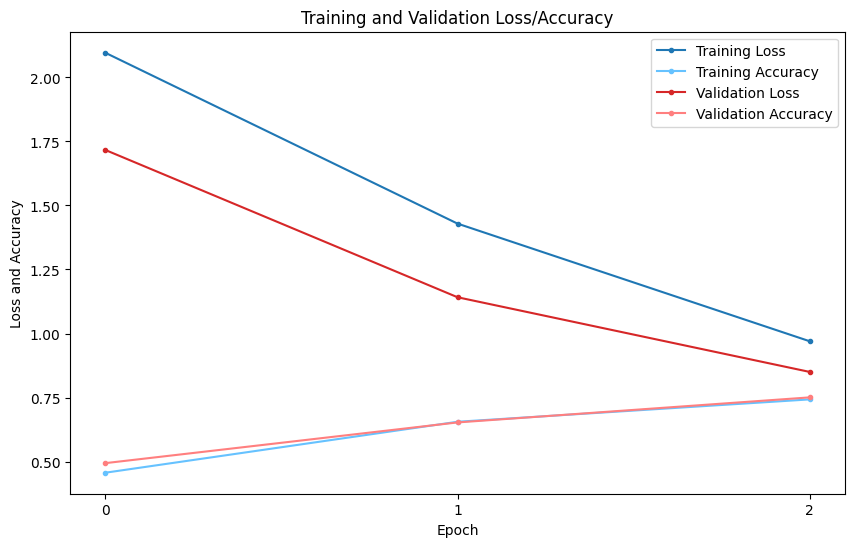


Test Sequence Length: 200
Testing Standard LSTM:
Segment 01/02 | Loss: 0.8612 | Accuracy: 0.7475
Segment 02/02 | Loss: 0.8508 | Accuracy: 0.7495

Final Test Loss: 0.8560 | Final Test Accuracy: 0.7485
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.1340 | Val Loss: 1.7087 | Training Accuracy: 0.3471 | Val Accuracy: 0.4390
Epoch 02 | Training Loss: 1.4428 | Val Loss: 1.1722 | Training Accuracy: 0.5971 | Val Accuracy: 0.6106
Epoch 03 | Training Loss: 1.0438 | Val Loss: 0.9360 | Training Accuracy: 0.7087 | Val Accuracy: 0.6755


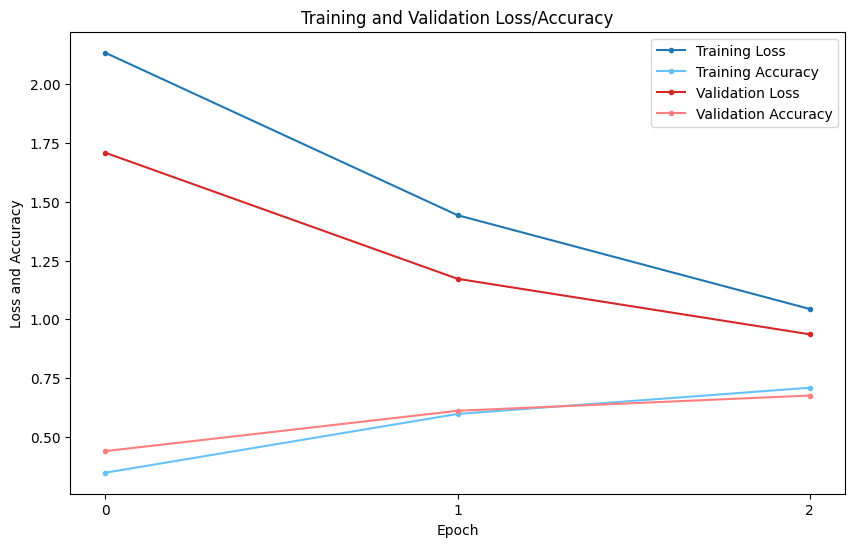


Test Sequence Length: 200
Testing Multiplicative LSTM:
Segment 01/02 | Loss: 0.9651 | Accuracy: 0.6623
Segment 02/02 | Loss: 0.9605 | Accuracy: 0.6615

Final Test Loss: 0.9628 | Final Test Accuracy: 0.6619
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.1425 | Val Loss: 1.7383 | Training Accuracy: 0.4029 | Val Accuracy: 0.4436
Epoch 02 | Training Loss: 1.4838 | Val Loss: 1.1903 | Training Accuracy: 0.6019 | Val Accuracy: 0.6542
Epoch 03 | Training Loss: 1.0088 | Val Loss: 0.8360 | Training Accuracy: 0.7816 | Val Accuracy: 0.7687


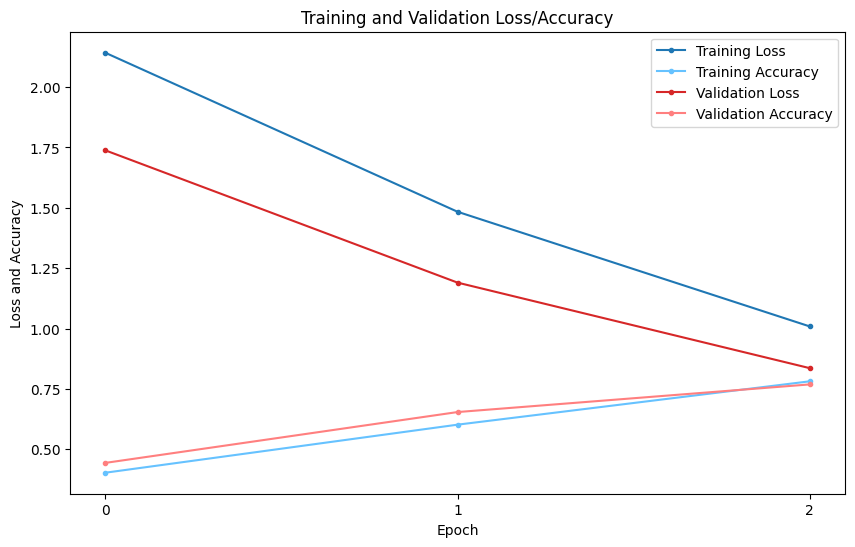


Test Sequence Length: 200
Testing Standard GRU:
Segment 01/02 | Loss: 0.8508 | Accuracy: 0.7637
Segment 02/02 | Loss: 0.8645 | Accuracy: 0.7526

Final Test Loss: 0.8577 | Final Test Accuracy: 0.7581
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.0724 | Val Loss: 1.6928 | Training Accuracy: 0.3859 | Val Accuracy: 0.4352
Epoch 02 | Training Loss: 1.4421 | Val Loss: 1.2387 | Training Accuracy: 0.5704 | Val Accuracy: 0.5850
Epoch 03 | Training Loss: 1.0686 | Val Loss: 0.9671 | Training Accuracy: 0.7184 | Val Accuracy: 0.6683


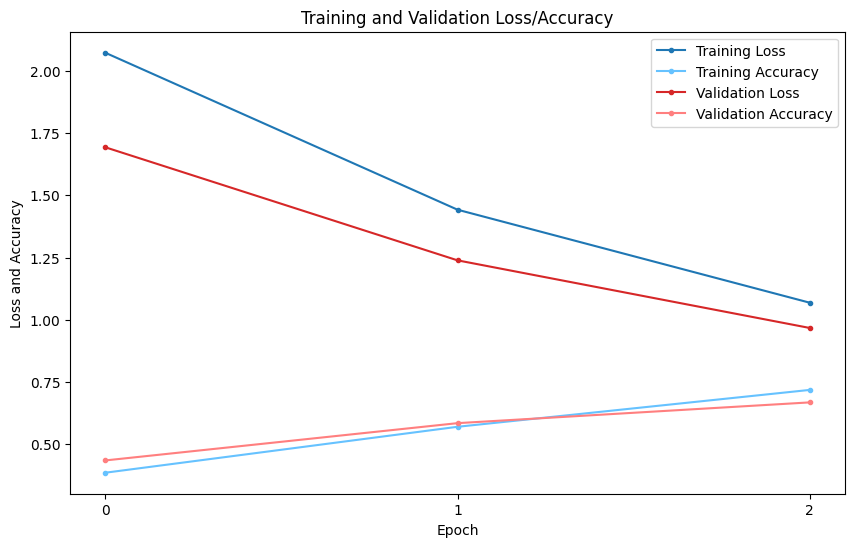


Test Sequence Length: 200
Testing Multiplicative GRU:
Segment 01/02 | Loss: 1.0114 | Accuracy: 0.6493
Segment 02/02 | Loss: 1.0035 | Accuracy: 0.6496

Final Test Loss: 1.0074 | Final Test Accuracy: 0.6494
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 3/3 on sequence length of 200 ***
Standard LSTM
Final Test Loss: 0.8560
Final Test Accuracy: 0.7485

Multiplicative LSTM
Final Test Loss: 0.9628
Final Test Accuracy: 0.6619

Standard GRU
Final Test Loss: 0.8577
Final Test Accuracy: 0.7581

Multiplicative GRU
Final Test Loss: 1.0074
Final Test Accuracy: 0.6494


===================================== Final Metrics Report =====================================

Model                  Sequence Length        Mean Accuracy          Std Error Accuracy     Mean Loss              Std Error Loss        
Standard LSTM          100                    0.7411                 0.0136                 0.9294        

In [10]:
run_copytask_benchmark()

# 4. Analyzing Copy Task Results
### Analysis of Results
### Observations on Multiplicative Effects